# Projet Temps Libre: Prédiction de mesures météorologiques

In [1]:
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
from collections import defaultdict
from prettytable import PrettyTable


from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout, Input


In [2]:
# création d'un tableau pour l'affichage des versions 
table_lib_version = PrettyTable()
table_lib_version.field_names = ["Library", "numpy", "pandas", "tensorflow"]
table_lib_version.add_row(["Version", np.__version__, pd.__version__, tf.__version__])

print(table_lib_version)

+---------+-------+--------+------------+
| Library | numpy | pandas | tensorflow |
+---------+-------+--------+------------+
| Version | 2.1.3 | 2.2.3  |   2.19.0   |
+---------+-------+--------+------------+


____________________________________________________________________________________________________________________

<div style="background-color: #C7F3A5; padding: 10px;">

Nous avons à notre disposition un jeu de données qui contient 4 mesures météorologiques, la température moyenne, l'humidité, la vitesse du vent et la pression moyenne, pour la période du 1er janvier 2013 jusqu'au 31 décembre 2016 pour les données d'entraînement et la période du 1er janvier 2017 jusqu'au 21 avril 2017 pour les données de test.

Nous avons construit plusieurs modèles LSTM. Ces modèles ont été entrainés sur des instances de durée de 30 jours. La valeur que l’on cherchait à prédire était la donné du 31e jour.
- Le 1er modèle prend en entrée une variable, la temperature, et nous donne en sortie la température prédite.
- Le 2e modèle prend en entrée les 4 mesures pour prédire la temperature 
- Le 3e modèle prédit chacune des variables à partir de toutes les variables 

Parmi les 3 modèles, le plus performant est le 1er avec une accuracy de 91,90%. On en conclut alors que l’utilisation de toutes les mesures n’améliore pas forcément la qualité des prédictions.

Nous allons donc concevoir un modèle basé sur un CNN. Ce modèle nous permettra de prédire la temperature en utilisant la température. Nous allons ensuite comparer le modèle CNN avec le modèle LSTM.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
We have a dataset that contains 4 meteorological measurements: average temperature, humidity, wind speed, and average pressure, for the period from January 1, 2013, to December 31, 2016, for training data and from January 1, 2017, to April 21, 2017, for testing data.

We have built several LSTM models. These models were trained on 30-day long instances. The value we aimed to predict was the data for the 31st day.

- The 1st model takes one input variable, the temperature, and outputs the predicted temperature.
- The 2nd model takes all 4 measurements to predict the temperature.
- The 3rd model predicts each variable using all the variables.

Among the 3 models, the most performant is the 1st one with an accuracy of 91.90%. We conclude that using all the measurements does not necessarily improve the quality of the predictions.

We will now design a model based on a CNN. This model will allow us to predict the temperature using just the temperature data. We will then compare the CNN model with the LSTM model.
</div>

____________________________________________________________________________________________________________________

## L'approche CNN

Nous avons choisi de travailler avec les modèles convolutionnels. L’utilisation des CNN sur des séries temporelles peut sembler inhabituelle étant donné que les CNN sont généralement associés au traitement d’images. Grâce à l'utilisation de filtres convolutionnels ce type de réseau de neurones est capable de repérer des motifs importants dans les données, même si ces motifs se produisent à différents moments dans la série temporelle. 
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

We have chosen to work with convolutional models. Using CNNs on time series may seem unusual since CNNs are generally associated with image processing. However, thanks to the use of convolutional filters, this type of neural network is capable of identifying important patterns in the data, even if these patterns occur at different times in the time series.

### *TimesNet*
Cette vision a été présenté dans l’article **“TimesNet: Temporal 2D-Variation Modelling for General Time Series Analysis”** (publié par H. Wu, T. Hu, Y. Liu, H. Zhou, J. Wang, M. Long). Dans cet article le modèle *TimesNet* prend en compte la multipériodicité dans des series temporelles. Par exemple la température présente à la fois une période quotidienne et annuelle. Habituellement, il fait plus chaud pendant la journée que pendant la nuit, et plus chaud pendant l'été que pendant l'hiver.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

This vision was presented in the paper **"TimesNet: Temporal 2D-Variation Modelling for General Time Series Analysis"** (published by H. Wu, T. Hu, Y. Liu, H. Zhou, J. Wang, M. Long). In this paper, the TimesNet model accounts for multiperiodicity in time series. For example, temperature has both a daily and an annual period. Typically, it is warmer during the day than at night, and warmer in the summer than in the winter.
![temp.png](../Images/temp.png)


Sur le graphique ci-dessus on voit bien que chaque année la température évolue de la même manière.

Dans une série temporelle unidimensionnelle ces multiples périodes se chevauchent et interagissent les unes avec les autres, ce qui rend difficile de les séparer et de les modéliser individuellement. Ainsi, les auteurs de l'article proposent de remodeler la série dans un espace en 2D pour modéliser les variations *intra-période* et *inter-période*.

En reprenant l'exemple précédent, la variation *intra-période* serait la façon dont la température varie au sein d'une journée, et la variation *inter-période* serait la façon dont la température varie d'une année à l’autre.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

In the graph above, we can clearly see that each year the temperature evolves in the same way.

In a unidimensional time series, these multiple periods overlap and interact with each other, making it difficult to separate and model them individually. Therefore, the authors of the paper propose reshaping the series into a 2D space to model the *intra-period* and *inter-period* variations.

Referring to the previous example, the *intra-period* variation would be how the temperature changes within a day, and the *inter-period* variation would be how the temperature changes from one year to another.

### L’architecture du *TimesNet*
Le schema suivant explique l’architecture du *TimesNet*:
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

The following diagram explains the architecture of TimesNet:
![timesnet.png](../Images/timesnet.png)


Dans chaque **TimesBlock** $\mathcal{l}$, nous pouvons voir que la série subit d'abord une transformée de Fourier rapide (FFT) pour trouver les top-*k* périodes dans la série temporelle (i.e. les périodes ayant les amplitudes les plus importantes). 

En fonction des fréquences sélectionnées et des périodes estimées, nous obtenons un ensemble de tensors 2D: $\{X^1_{2D}, \dots, X^k_{2D}\}$, qui indique *k* différentes variations temporelles 2D, dérivées de différentes périodes.

Une fois que la série a été soumise à la transformée de Fourier et que des tensors 2D ont été créés pour les *k* premières périodes, ces tensors 2D sont envoyées au bloc **Inception**. L'idée principale du bloc **Inception** est d'avoir une représentation efficace des données en la gardant clairsemée. De cette manière, nous pouvons techniquement augmenter la taille d'un réseau neuronal tout en le maintenant efficace du point de vue computationnel. Cela est réalisé en effectuant diverses opérations de convolution et de regroupement, puis en concaténant le tout.

Ensuite, une **Agrégation Adaptative** est utilisée. Pour l'effectuer, la représentation 2D doit d'abord être remodelée en 1D. **L'Agrégation Adaptative** est utilisée, car différentes périodes ont différentes amplitudes, ce qui indique leur importance respective. C'est pourquoi la sortie de la FFT est également envoyée à une couche softmax, afin que l'agrégation soit effectuée en tenant compte de l'importance relative de chaque période.

Les données agrégées constituent la sortie d'un seul bloc **TimesBlock**. Ensuite, plusieurs blocs **TimesBlock** sont empilés avec des connexions résiduelles pour créer le modèle TimesNet.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">


In each **TimesBlock** $\mathcal{l}$, we can see that the series first undergoes a Fast Fourier Transform (FFT) to identify the top-*k* periods in the time series (i.e., the periods with the highest amplitudes).

Based on the selected frequencies and estimated periods, we obtain a set of 2D tensors: $\{X^1_{2D}, \dots, X^k_{2D}\}$, representing *k* different 2D temporal variations derived from different periods.

Once the series has been processed by the Fourier transform and 2D tensors have been created for the top-*k* periods, these 2D tensors are passed to the **Inception** block. The main idea of the **Inception** block is to achieve an efficient representation of the data by keeping it sparse. This way, we can technically increase the size of a neural network while maintaining its computational efficiency. This is accomplished by performing various convolution and pooling operations and then concatenating the results.

Next, an **Adaptive Aggregation** is applied. To perform this, the 2D representation must first be reshaped into 1D. **Adaptive Aggregation** is used because different periods have different amplitudes, indicating their respective importance. This is why the output of the FFT is also fed into a softmax layer, ensuring that the aggregation is performed while accounting for the relative importance of each period.

The aggregated data constitutes the output of a single **TimesBlock**. Then, multiple **TimesBlock** blocks are stacked with residual connections to build the TimesNet model.

____________________________________________________________________________________________________________________

## Adaptation de la méthode de l'article
Etant donné la complexité du modèle **TimesNet**, nous n'allons pas l'appliquer directement tel qu'il est. Cependant, nous allons reprendre l'idée de la periodicité de nos données.

La façon dont nous allons procéder pour construire notre modèle CNN pour la prédiction de la température est la suivante: 

- Nous avons remarqué que chaque année l'évolution de la température se répète. Nous allons donc premièrement reshape nos données afin qu'ils soient regroupées de manière à ce que chaque élément de notre nouveau set de données soit constituer de tempértures prises au même jour, mais pas à la même année. Donc la variation *intra-période* serait la façon dont la température varie d'un jour à l'autre, et la variation *inter-période* serait la façon dont la température varie d'une année à l’autre.

- Nous allons ensuite diviser nos données par batch de 30, c'est-à-dire que nous allons prédire la température du 31e jour avec les températures des 30 jours précédents (comme dans le TP noté)
 
- Une fois que nos données auront des bonnes dimensions, on pourra entraíner notre modèle CNN avec les données Train, pour ensuite le tester avec les données Test.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

Given the complexity of the **TimesNet** model, we will not apply it directly as-is. However, we will adopt the idea of leveraging the periodicity in our data.

The approach we will follow to build our CNN model for temperature prediction is as follows:

- We observed that temperature patterns repeat every year. Therefore, we will first reshape our data so that each element in the new dataset consists of temperatures recorded on the same day but across different years. Thus, the *intra-period* variation would represent how temperature changes from day to day, while the *inter-period* variation would capture how temperature differs from year to year.
  
- Next, we will split the data into batches of 30, meaning we will predict the temperature of the 31st day using the temperatures of the previous 30 days (as in the graded exercise).
  
-Once our data has the correct dimensions, we will train our CNN model on the training set and then evaluate it on the test set.

____________________________________________________________________________________________________________________

<div style="background-color: #F6BDD1; color:white; padding: 10px;">
    <h1>I. Préparation des données </h1>
</div>

In [3]:
train = pd.read_csv("../Datasets/DailyClimateTrain.csv")
test = pd.read_csv("../Datasets/DailyClimateTest.csv")

**Température moyenne**

Nous allons d'entrée supprimer les mesures qui nous intéressent pas.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

We will start by removing the measures that do not interest us.

In [4]:
train = train.drop(columns=["humidity","wind_speed","meanpressure"])
test = test.drop(columns=["humidity","wind_speed","meanpressure"])

**Valeurs aberrantes**

Nous allons supprimer le 29 février 2016, afin de simplifier la future partie reshape.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

We will remove February 29, 2016, to simplify the upcoming reshape process.

In [5]:
train = train[train["date"] != "2016-02-29"]

**Normalisation**

In [6]:
scaler_data = MinMaxScaler()

train_scaled = scaler_data.fit_transform(train.drop(columns=["date"]))
test_scaled = scaler_data.fit_transform(test.drop(columns=["date"]))

Regrouppons nos données normalisées dans un dataframe.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
Let's group our scaled data into a dataframe.

In [7]:
scale = pd.DataFrame(train_scaled, 
                           columns=["meantemp"]).assign(date=train["date"])
df_scaled = scale.drop(columns=["date"])

df_scaled.shape

(1460, 1)

____________________________________________________________________________________________________________________

### Série bidimensionnelle

Nous allons utiliser la focntion reshape pour transformer nos données de dimensions (1460,1) en dimensions (4,365,1), nous allons ensuite les transposer afin d'obtenir les dimensions souhaitées, c'est à dire (365,4,1)

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
We will use the reshape function to transform our data from dimensions (1460,1) to (4,365,1). Then, we will transpose them to obtain the desired dimensions, which are (365,4,1).

In [8]:
matrix_data = df_scaled[["meantemp"]].values
X_2D = matrix_data.reshape(4, 365, 1)
X_2D = np.transpose(X_2D, (1, 0, 2))

X_2D.shape

(365, 4, 1)

### Batch

Nous allons maintenant créer nos batch de n = 30 jours.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
We will now create our batches of n=30 days.

In [9]:
def get_batch(n, data):
    """
    Génère des séquences de longueur donnée à partir d'une série temporelle.

    Paramètres :
    - data : np.array, série temporelle normalisée
    - n : int, nombre de timesteps à inclure dans chaque séquence (sans compter la valeur cible)

    Retourne :
    - sequences : np.array, tableau contenant les séquences générées
    """
    return np.array([data[i:i+(n+1)] for i in range(len(data)-n)])

In [10]:
x_2d = get_batch(30, X_2D) 

Essayons de prendre un batch de taille plus petite, par exemple prenons n=7.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
Let's try using a smaller batch size, for example n=7.

In [11]:
x2_2d = get_batch(7, X_2D) 

### Train-Test split

$\to$ **Train** 

On sélectionne les 30 premiers jours de chaque tranche pour X_train et le 31e jour de chaque tranche pour y_train.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
We select the first 30 days of each segment for X_train and the 31st day of each segment for y_train.

In [12]:
X_train = x_2d[:, :-1]  
y_train = x_2d[:, -1] 

X_train.shape, y_train.shape

((335, 30, 4, 1), (335, 4, 1))

Et pour le batch 7, nous faisons la même chose.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
And for the batch of 7, we do the same.

In [13]:
X2_train = x2_2d[:, :-1]  
y2_train = x2_2d[:, -1] 

X2_train.shape, y2_train.shape

((358, 7, 4, 1), (358, 4, 1))

$\to$ **Test**

Le jeu de données Test qui nous a été fournis ne contient des mesures seulement pour une seule année. Or, pour faire des prédictions les dimensions des données de test et d'entraînement doivent être compatibles. Nous avons donc besoin de compléter d'une manière ou d'une autre nos données Test.

Pour ce faire, nous avons choisi de répéter 4 fois les données de la même année. Cette approche semble être raisonnable et la plus appropriée à notre situation car les tendances saisonnières sont stables d'une année à l'autre. Néanmoins, il est clair que cette méthode peut introduire un biais dans le modèle. 

Nous aurions pu également diminuer la taille de Train et donc compléter le Test avec les données amputées. Par exemple enlever la période à partir du 1er janvier 2016 et la rajouter dans les données de test afin d'obtenir les bonnes dimensions. 

Une autre solution possible serait d'essayer de trouver des données climatiques provenant de sources externes à condition que ces dernières soient cohérentes avec nos donnés de base. 

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
The provided test dataset contains measurements for only one year. However, for making predictions, the dimensions of the test and training data must be compatible. Therefore, we need to supplement our test data in some way.

To achieve this, we have chosen to repeat the data from the same year four times. This approach appears reasonable and most suitable for our situation since seasonal trends are generally stable from year to year. However, we acknowledge that this method may introduce bias into the model.

An alternative approach could be to reduce the size of the training dataset and use the removed data to supplement the test set. For example, we could remove data from January 1, 2016, onward and add it to the test dataset to ensure the correct dimensions.

Another possible solution would be to source external climate data, provided that it aligns well with our existing dataset.

In [14]:
# répéter la même année 
test_scaled_2 = np.tile(test_scaled, (1,4))

In [15]:
# batch 30
test_2d = get_batch(30, test_scaled_2) 

In [16]:
# batch 7
test2_2d = get_batch(7, test_scaled_2) 

On sélectionne les 30 premiers jours de chaque tranche pour X_test et le 31e jour de chaque tranche pour y_test.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
We select the first 30 days of each segment for X_test and the 31st day of each segment for y_test.

In [17]:
X_test = test_2d[:,:-1]
y_test = test_2d[:,-1,0]

X_test.shape, y_test.shape

((84, 30, 4), (84,))

In [18]:
# batch 7
X2_test = test2_2d[:,:-1]
y2_test = test2_2d[:,-1,0]

X2_test.shape, y2_test.shape

((107, 7, 4), (107,))

On adapte les dimensions de X_test aux dimensions de X_train.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
We adjust the dimensions of X_test to match the dimensions of X_train.

In [19]:
X_test = X_test.reshape((84, 30, 4, 1))
X_test.shape

(84, 30, 4, 1)

In [20]:
X2_test = X2_test.reshape((107, 7, 4, 1))
X2_test.shape

(107, 7, 4, 1)

____________________________________________________________________________________________________________________


<div style="background-color: #F6BDD1; color:white; padding: 10px;">
    <h1>II. Modèles à convolution </h1>
</div>

### 1er modèle

Nous allons tester le 1er modèle avec une seule couche convolutionnelle et une couche Dense.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
We will test the first model with a single convolutional layer and a dense layer.


$\to$ **Batch 30** 

In [21]:
model = Sequential()

model.add(Input(shape=(30,4,1))) 
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="linear")) 

model.compile(optimizer="adam",loss="mse")

2025-03-25 16:20:44.089760: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-25 16:20:44.089920: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-25 16:20:44.089927: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1742916044.090389 2379375 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1742916044.090437 2379375 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Nous allons créer une fonction qui permet de prédire les valeurs, puis récupèrer les vraies valeurs avec inverse_transform. Ensuite on ramène les dimensions de Y_test à celle des prédictions. On évalue également la justesse des prédictions, en calculant r2_score. Plus ce score est proche de 1 meilleures sont les prédictions.
On plot enfin les vraies températures contre les prédictions.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
We will create a function to predict the values, then retrieve the true values using inverse_transform. After that, we will reshape the dimensions of y_test to match the predictions. We will also evaluate the accuracy of the predictions by calculating the R² score. The closer this score is to 1, the better the predictions. Finally, we will plot the true temperatures against the predictions.

In [22]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test,scaler_data ):
    """
    Entraîne un modèle, effectue des prédictions, puis évalue la performance sur les données de test.

    Paramètres :
    - model : objet du modèle d'apprentissage, déjà entraîné ou à entraîner
    - X_train : np.array, caractéristiques des données d'entraînement
    - y_train : np.array, étiquettes des données d'entraînement
    - X_test : np.array, caractéristiques des données de test
    - y_test : np.array, étiquettes des données de test
    - scaler_data : objet de normalisation (scaler) utilisé pour transformer les données

    Retourne :
    - score : float, le coefficient de détermination R² qui mesure la qualité du modèle
    """

    predictions = model.predict(X_test)
    
    # descale les prédictions
    predictions = scaler_data.inverse_transform(predictions)
    y_test = scaler_data.inverse_transform(y_test.reshape(-1, 1))
    
    # plot les prédictions et les vraies
    plt.plot(y_test, label="Température réelle", color="#F08CAE")
    plt.plot(predictions, label="Température prédite", color="#A0C4E2")
   
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Légende à l'extérieur
    plt.xlabel("Jour")
    plt.ylabel("Température moyenne")
    plt.show()
    
    # accuracy score
    score = r2_score(y_test, predictions)
    
    return round(score,4)


In [23]:
model.fit(X_train, y_train, batch_size=32, epochs=60, verbose=0)

2025-03-25 16:20:44.824186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Créons une liste afin de pouvoir récupérer plus facilement les résultats.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
We can create a list to store the results.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


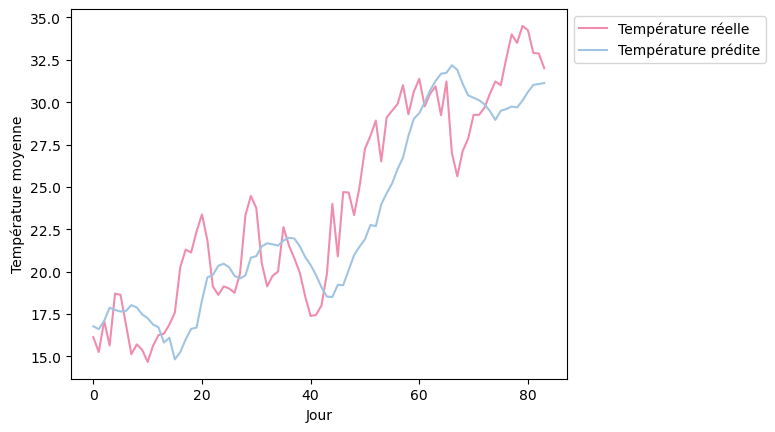

In [24]:
results = []

model_accuracy = train_and_evaluate_model(model, X_train, y_train, X_test, y_test, scaler_data)
results.append(("Model 1 -30", model_accuracy))

$\to$ **Batch 7** 

In [25]:
model_7 = Sequential()

model_7.add(Input(shape=(7,4,1))) 
model_7.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu"))
model_7.add(MaxPooling2D(pool_size=(2, 2)))
model_7.add(Flatten())
model_7.add(Dense(128, activation="relu"))
model_7.add(Dense(1, activation="linear")) 

model_7.compile(optimizer="adam",loss="mse")

In [26]:
model_7.fit(X2_train, y2_train, batch_size=32, epochs=60, verbose=0)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


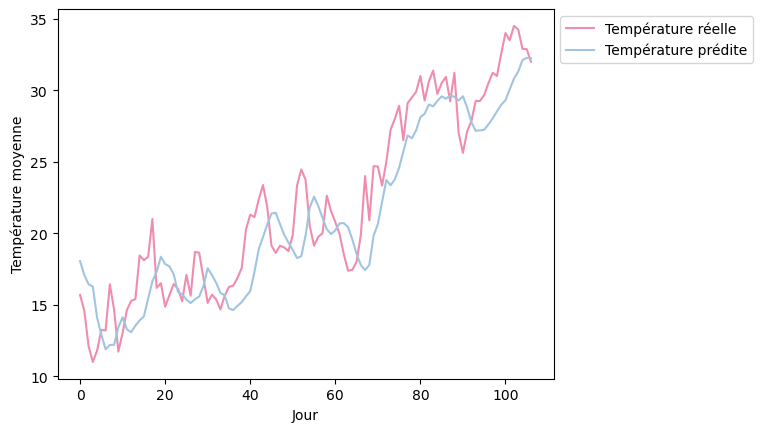

In [27]:
model_7_accuracy = train_and_evaluate_model(model_7, X2_train, y2_train, X2_test, y2_test, scaler_data)
results.append(("Model 1 - 7", model_7_accuracy))

Nous n'obtenons pas de très bons résultats pour le 31e jours. Il faut essayer de changer de modèle.

Cependant, l'accuracy est meilleure pour la prédictions du 8e jour.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
We are not getting very good results for the 31st day. We need to try changing the model.

However, the accuracy is better for the predictions of the 8th day.

### 2e modèle

Nous allons augmenter la profondeur du modèle en rajoutant une deuxième couche Conv2D afin d'essayer d'améliorer nos prédictions.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
We will increase the model's depth by adding a second Conv2D layer in order to try to improve our predictions.


$\to$ **Batch 30**

In [28]:
model2 = Sequential()

model2.add(Input(shape=(30,4,1))) 

model2.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, kernel_size=(2, 2), activation="relu", padding="same"))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(128, activation="relu"))
model2.add(Dense(1, activation="linear")) 

model2.compile(optimizer="adam",loss="mse")

In [29]:
model2.fit(X_train, y_train, batch_size=32, epochs=60, verbose=0)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x157c1bc70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


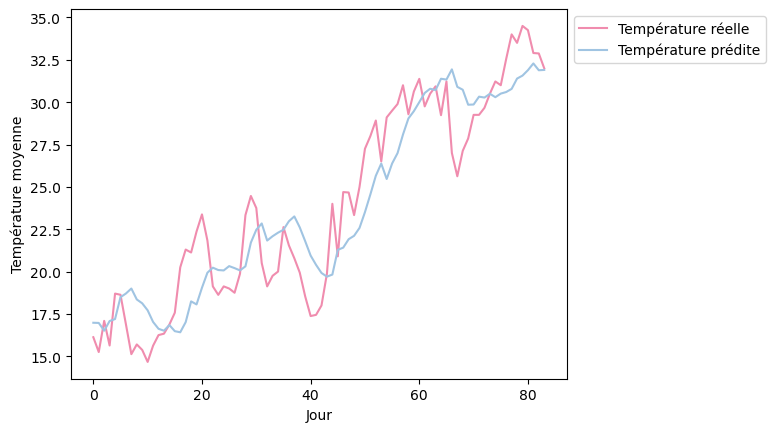

In [30]:
model2_accuracy = train_and_evaluate_model(model2, X_train, y_train, X_test, y_test, scaler_data)
results.append(("Model 2 - 30", model2_accuracy))

$\to$ **Batch 7**

In [31]:
model2_7 = Sequential()

model2_7.add(Input(shape=(7,4,1))) 

model2_7.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"))
model2_7.add(MaxPooling2D(pool_size=(2, 2)))

model2_7.add(Conv2D(64, kernel_size=(2, 2), activation="relu", padding="same"))
model2_7.add(MaxPooling2D(pool_size=(2, 2)))

model2_7.add(Flatten())
model2_7.add(Dense(128, activation="relu"))
model2_7.add(Dense(1, activation="linear")) 

model2_7.compile(optimizer="adam",loss="mse")

In [32]:
model2_7.fit(X2_train, y2_train, batch_size=32, epochs=60, verbose=0)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


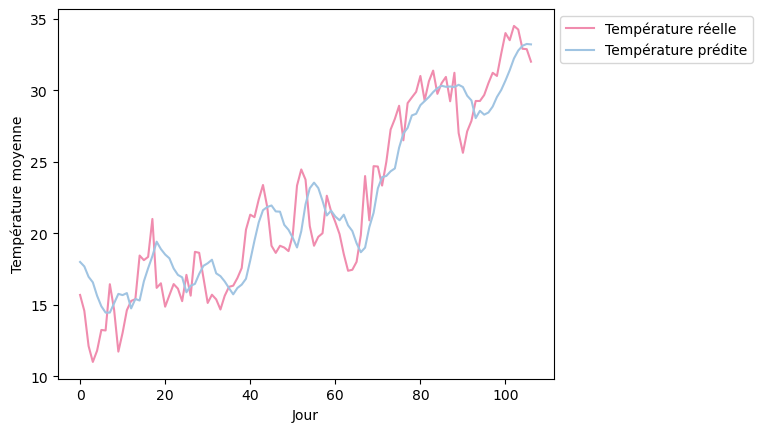

In [33]:
model2_7_accuracy = train_and_evaluate_model(model2_7, X2_train, y2_train, X2_test, y2_test, scaler_data)
results.append(("Model 2 - 7", model2_7_accuracy))

Nous avons amélioré les résultats pour les deux batch.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
We have improved the results for both batches.

### 3e modèle

Nous allons rajouter une autre couche Dense pour essayer d'avoir de meilleurs résultats.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

We will add another Dense layer to try to achieve better results.

$\to$ **Batch 30**

In [34]:
model3 = Sequential()

model3.add(Input(shape=(30,4,1))) 

model3.add(Conv2D(100, kernel_size=(3, 3), activation="relu", padding="same"))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(150, kernel_size=(2, 2), activation="relu", padding="same"))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(128, activation="relu"))
model3.add(Dense(1, activation="linear")) 

model3.compile(optimizer="adam",loss="mse")

In [35]:
model3.fit(X_train, y_train, batch_size=32, epochs=60, verbose=0)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


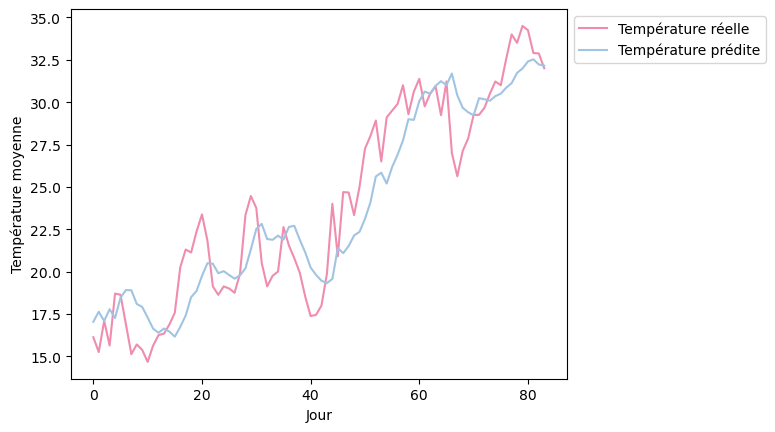

In [36]:
model3_accuracy = train_and_evaluate_model(model3, X_train, y_train, X_test, y_test, scaler_data)
results.append(("Model 3 - 30", model3_accuracy))

$\to$ **Batch 7**

In [37]:
model3_7 = Sequential()

model3_7.add(Input(shape=(7,4,1))) 

model3_7.add(Conv2D(100, kernel_size=(3, 3), activation="relu", padding="same"))
model3_7.add(MaxPooling2D(pool_size=(2, 2)))

model3_7.add(Conv2D(150, kernel_size=(2, 2), activation="relu", padding="same"))
model3_7.add(MaxPooling2D(pool_size=(2, 2)))

model3_7.add(Flatten())
model3_7.add(Dense(128, activation="relu"))
model3_7.add(Dense(1, activation="linear")) 

model3_7.compile(optimizer="adam",loss="mse")

In [38]:
model3_7.fit(X2_train, y2_train, batch_size=32, epochs=60, verbose=0)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


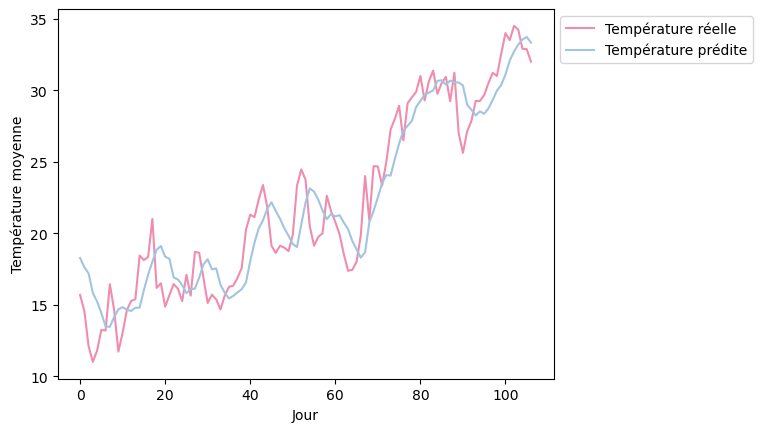

In [39]:
model3_7_accuracy = train_and_evaluate_model(model3_7, X2_train, y2_train, X2_test, y2_test, scaler_data)
results.append(("Model 3 - 7", model3_7_accuracy))

____________________________________________________________________________________________________________________

<div style="background-color: #F6BDD1; color:white; padding: 10px;">
    <h1>III. Modèles à LSTM </h1>
</div>

Testons maintenant le modèle LSTM. Nous gardons la même démarche que pour les CNN. Nous testons également les deux tailles de batch.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
Let's now test the LSTM model. We'll follow the same approach as with the CNNs. We'll also test both batch sizes.

$\to$ **Batch 30**

In [40]:
X_1d = get_batch(30,train_scaled)

In [41]:
X_train_LSTM = X_1d[:,:-1]
y_train_LSTM = X_1d[:,-1,0]

X_train_LSTM.shape, y_train_LSTM.shape

((1430, 30, 1), (1430,))

In [42]:
X_train_LSTM = X_train_LSTM.reshape(-1,1,30)
X_train_LSTM.shape

(1430, 1, 30)

In [43]:
test_1d = get_batch(30,test_scaled)

In [44]:
X_test_LSTM = test_1d[:,:-1]
y_test_LSTM = test_1d[:,-1,0]

X_test_LSTM.shape, y_test_LSTM.shape

((84, 30, 1), (84,))

In [45]:
X_test_LSTM = X_test_LSTM.reshape(-1,1,30)

In [46]:
X_test_LSTM.shape

(84, 1, 30)

In [47]:
model_LSTM=Sequential()
model_LSTM.add(Input(shape=(1,30))) 
model_LSTM.add(LSTM(100, return_sequences=True))
model_LSTM.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2))
model_LSTM.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2))
model_LSTM.add(LSTM(100, return_sequences=False, recurrent_dropout=0.2))
model_LSTM.add(Dense(1, activation="linear"))

model_LSTM.compile(optimizer="adam", loss="mse")

In [48]:
model_LSTM.fit(X_train_LSTM, y_train_LSTM, batch_size=32, epochs=60, verbose =0)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step


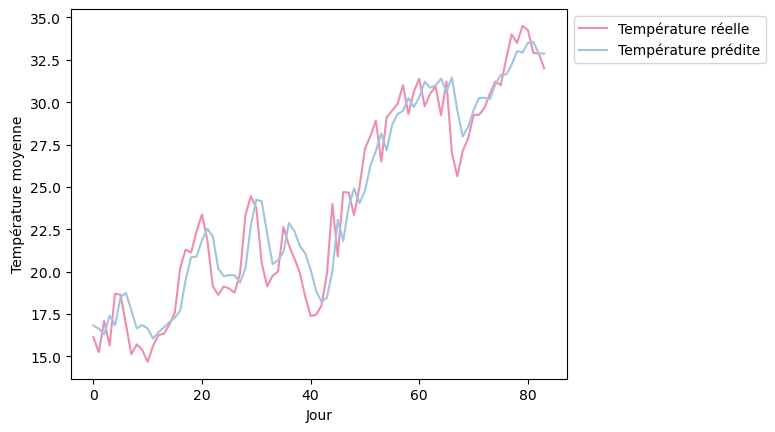

In [49]:
model_LSTM_accuracy = train_and_evaluate_model(model_LSTM, X_train_LSTM, y_train_LSTM, X_test_LSTM, y_test_LSTM, scaler_data)
results.append(("Model LSTM - 30", model_LSTM_accuracy))

$\to$ **Batch 7**

In [50]:
X2_1d = get_batch(7,train_scaled)

In [51]:
X2_train_LSTM = X2_1d[:,:-1]
y2_train_LSTM = X2_1d[:,-1,0]

X2_train_LSTM.shape, y2_train_LSTM.shape

((1453, 7, 1), (1453,))

In [52]:
X2_train_LSTM = X2_train_LSTM.reshape(-1,1,7)
X2_train_LSTM.shape

(1453, 1, 7)

In [53]:
test2_1d = get_batch(7,test_scaled)

In [54]:
X2_test_LSTM = test2_1d[:,:-1]
y2_test_LSTM = test2_1d[:,-1,0]

X2_test_LSTM.shape, y2_test_LSTM.shape

((107, 7, 1), (107,))

In [55]:
X2_test_LSTM = X2_test_LSTM.reshape(-1,1,7)

In [56]:
X2_test_LSTM.shape

(107, 1, 7)

In [57]:
model2_LSTM=Sequential()
model2_LSTM.add(Input(shape=(1,7))) 
model2_LSTM.add(LSTM(100, return_sequences=True))
model2_LSTM.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2))
model2_LSTM.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2))
model2_LSTM.add(LSTM(100, return_sequences=False, recurrent_dropout=0.2))
model2_LSTM.add(Dense(1, activation="linear"))

model2_LSTM.compile(optimizer="adam", loss="mse")

In [58]:
model2_LSTM.fit(X2_train_LSTM, y2_train_LSTM, batch_size=32, epochs=60, verbose =0)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 566ms/step


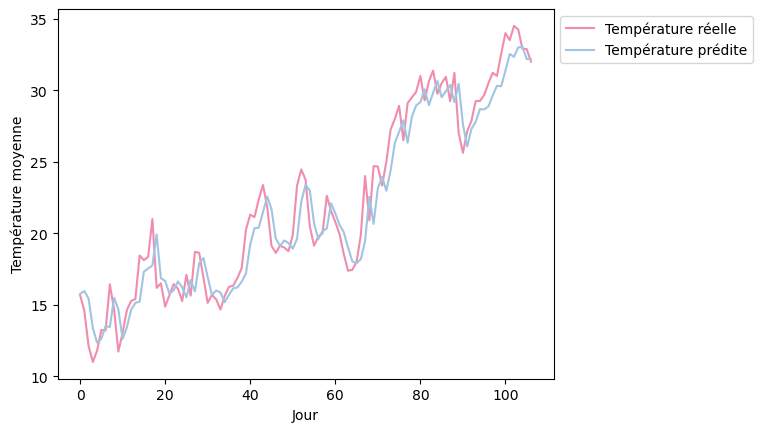

In [59]:
model2_LSTM_accuracy = train_and_evaluate_model(model2_LSTM, X2_train_LSTM, y2_train_LSTM, X2_test_LSTM, y2_test_LSTM, scaler_data)
results.append(("Model LSTM - 7", model2_LSTM_accuracy))

<div style="background-color: #F6BDD1; color:white; padding: 10px;">
    <h1>IV. Comparaisons de modèles </h1>
</div>


Comparons les résultats que nous avons obtenus:

In [60]:
df_res = pd.DataFrame(results, columns=["Modèle", "Accuracy"])
df_res_order = df_res.reindex([0, 2, 4, 6, 1, 3, 5, 7])

table_res = PrettyTable()

table_res.field_names = df_res_order.columns.tolist()

for _, row in df_res_order.iterrows():
    table_res.add_row(row.tolist())

print(table_res)


+-----------------+----------+
|      Modèle     | Accuracy |
+-----------------+----------+
|   Model 1 -30   |  0.7486  |
|   Model 2 - 30  |  0.8382  |
|   Model 3 - 30  |  0.8532  |
| Model LSTM - 30 |  0.9206  |
|   Model 1 - 7   |  0.8192  |
|   Model 2 - 7   |  0.8735  |
|   Model 3 - 7   |  0.8842  |
|  Model LSTM - 7 |  0.9295  |
+-----------------+----------+


Nous avons tester 3 modèles covolutionnels. Le meilleur modèle parmi les 3 proposés est le **modèle 2** qui a une accuracy de **87,09%** pour la prédictions du 31e jour et une accuracy de **87,73%** pour la prédictions du 31e jour. 

*Il faut noter que le modèle 2 n'est pas toujours plus pérformant que le 3*

Cependant, l'accuracy des modèles LSTM est nettement meilleure que celle des modèles 3.

Nous avons également comparés les temps de calculs. D'après nos résultats les modèles CNN prennent moins de temps d'entraînement que le modèle LSTM.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
We tested 3 convolutional models. The best model among the 3 proposed is model 2, which has an accuracy of 87.09% for the 31st day prediction and an accuracy of 87.73% for the 8th day prediction.

*It is important to note that model 2 is not always more performant than model 3.*

However, the accuracy of the LSTM models is significantly better than that of model 3.

We also compared the computation times. According to our results, the CNN models take less training time than the LSTM model.

____________________________________________________________________________________________________________________

<div style="background-color: #F6BDD1; color:white; padding: 10px;">
    <h1>V. Conclusion </h1>
</div>
Pour la prédiction de la température le modèle LSTM est plus précis que notre meilleur modèle CNN. Ce résultat n'est pas choquant car les modèles LSTM sont généralement utilisés pour traiter et faire des prédictions sur des séquences de données. En revanche, les modèles CNN sont conçus pour exploiter la "corrélation spatiale" dans les données (ces modèles sont généralement associés aux images). 

Même si notre jeu de données contient des relations "spatiales" entre les variables, ces relations ne semblent pas être aussi importantes que la séquence temporelle.

Cependant, une des raisons pour lesquelles nous pouvons préfèrer d'utiliser les CNN plutôt que les LSTM est le temps d'entraînement nécessaire. La nature séquentielle des LSTM pénalise ces modèles au niveau du temps de calculs. 


Le choix entre les deux modèles pourrait se baser sur les critères suiavnts:

- la nature des prédictions : les LSTM sont plus adaptés pour capturer les dépendances à long terme dans les données séquentielles, tandis que les CNN sont puissants pour apprendre des modèles "locaux" dans les données.

*Nos résultats CNN nous montrent que les modèles qui prédisaient le 8e jour avaient de meilleures performances que les prédictions du jour 31*

- la taile du jeu de données : les modèles CNN sont plus efficaces en temps de calculs grâce à leur capacité d'analyser différentes parties des données simultanément, c'est pourqoi les CNN peuvent utiliser les processeurs graphiques GPU pour accélérer le calcul.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
For temperature prediction, the LSTM model is more accurate than our best CNN model. This result is not surprising, as LSTM models are generally used to process and make predictions on sequences of data. On the other hand, CNN models are designed to exploit "spatial correlation" in data (these models are typically associated with images).

Although our dataset contains "spatial" relationships between the variables, these relationships don't seem as important as the temporal sequence.

However, one reason why we might prefer using CNNs over LSTMs is the training time required. The sequential nature of LSTMs penalizes these models in terms of computation time.

The choice between the two models could be based on the following criteria:

- nature of the predictions: LSTMs are better suited to capturing long-term dependencies in sequential data, while CNNs are powerful for learning "local" patterns in data.

*Our CNN results show that models predicting the 8th day had better performance than predictions for day 31.*

- size of the dataset: CNN models are more efficient in terms of computation time due to their ability to analyze different parts of the data simultaneously. This is why CNNs can leverage GPU processors to accelerate the computation.